In [ ]:
# Working on splitting the dataset by low/high recurrence scores,
# then tripling the number of high score samples to balance the dataset

import torch
import random
from scripts.dataset_loader import MicroscopyDataset

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Load dataset
dataset = MicroscopyDataset(
    csv_file=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData/labels.csv",
    root_dir=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData",
    transform=None
)

In [ ]:
# Sample-based dataset splitting
samples_dict = dataset.samples  # Dictionary {sample_id: [list of FOVs]}
samples_list = list(samples_dict.items())  # Convert to list of tuples

In [ ]:
# Create a dictionary to hold all samples with high recurrence scores (30 or greater)
high_samples_dict = {}

# Iterate through sample_dict
for sample_id, sample_data in samples_dict.items():
    if sample_id in dataset.data_frame['sample_id'].values:
        score = dataset.data_frame.loc[dataset.data_frame['sample_id'] == sample_id, 'score_range'].values[0]
        if score == 'high':
            high_samples_dict[sample_id] = sample_data # Copy to new dictionary

high_samples_list = list(high_samples_dict.items())

In [48]:
import torch
from torch.utils.data import DataLoader
from scripts.loss_functions import FocalLoss
from models.microscopy_cnn import MicroscopyCNN
from scripts.dataset_loader import MicroscopyDataset
import torch.optim as optim
import torch.nn as nn
import random
import torchvision.transforms.v2 as tvt
from scripts.model_metrics import score_model
import matplotlib.pyplot as plt
import pandas as pd

In [50]:
# Load dataset

model = MicroscopyCNN()
data = MicroscopyDataset(
    csv_file="../data/newData/labels.csv",
    root_dir="../data/newData",
    transform=None)

# DataLoaders
dataloader = DataLoader(dataset=data, batch_size=64, shuffle=True)

def flatten_fovs(sample_list):
    return [fov for _, fovs in sample_list for fov in fovs]
data.samples = flatten_fovs(list(data.samples.items()))

for x, target in dataloader:
    print(x.shape)
    print(target.shape)
    break

Total unique samples found: 29
torch.Size([64, 4, 512, 512])
torch.Size([64])


In [60]:
x = torch.rand(5, 4, 512, 512)
out = model(x)
print(out)

tensor([[-9.1837],
        [-9.1879],
        [-9.1826],
        [-9.1805],
        [-9.1776]], grad_fn=<AddmmBackward0>)


_____________________________________________________
|	ROC-AUC                                 0.6423	|
|	Optimal Threshold from ROC            -11.1451	|
|	F1 Score                                0.5672	|
|	Optimal Threshold from F1            -358.5918	|
|	Average Precision                       0.5394	|
|	Accuracy at Threshold                   0.7931	|
|	Balanced Accuracy at Threshold          0.6981	|
_____________________________________________________


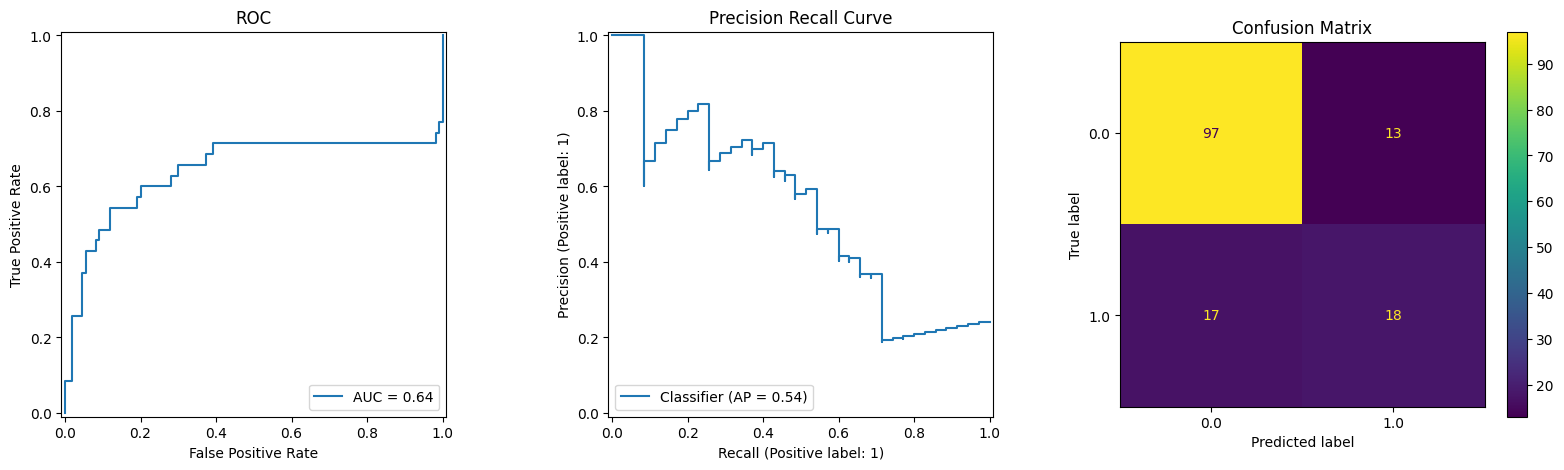

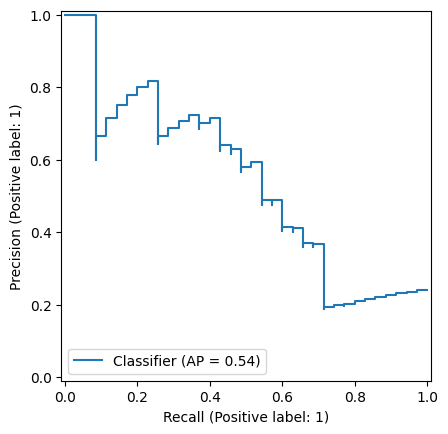

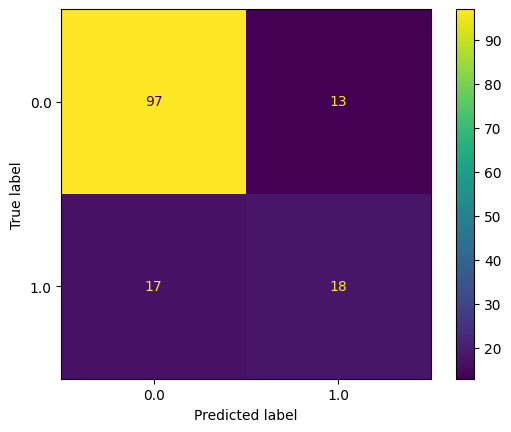

In [64]:
from models.microscopy_cnn import MicroscopyCNN
from scripts.model_metrics import score_model
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=data, batch_size=64, shuffle=True)

model = MicroscopyCNN()
model.load_state_dict(torch.load(r'C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\results\classification_model_epoch2250.pt', map_location=torch.device('cpu'),weights_only=True))

scores,fig = score_model(model, dataloader,print_results=True, make_plot=True, threshold_type='roc')

In [ ]:

##------------------------------------------------------------##

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Hyperparameters
batch_size = 16
epochs = 2500
learning_rate = 1e-6

# Transformations for training set
train_transform = tvt.Compose([
    tvt.RandomVerticalFlip(p=0.25),
    tvt.RandomHorizontalFlip(p=0.25),
    tvt.RandomRotation(degrees=(-180, 180))])

# Transforms for artificial expansion of high-score data
augment_transform = tvt.Compose([
    tvt.RandomVerticalFlip(p=0.5),
    tvt.RandomHorizontalFlip(p=0.5),
    tvt.RandomRotation(degrees=(-180, 180)),
    tvt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Load full dataset
full_dataset = MicroscopyDataset(
    csv_file=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData/labels.csv",
    root_dir=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData",
    transform=None
)


# Sample-based dataset splitting
samples_dict = full_dataset.samples  # Dictionary {sample_id: [list of FOVs]}
samples_list = list(samples_dict.items())  # Convert to list of tuples

In [ ]:

# Create a dictionary to hold all samples with high recurrence scores (30 or greater)
high_samples_dict = {}
# Iterate through sample_dict
for sample_id, sample_data in samples_dict.items():
    if sample_id in full_dataset.data_frame['sample_id'].values:
        score = full_dataset.data_frame.loc[full_dataset.data_frame['sample_id'] == sample_id, 'score_range'].values[0]
        if score == 'high':
            high_samples_dict[sample_id] = sample_data # Copy to new dictionary

high_samples_list = list(high_samples_dict.items())

high_score_samples = [(sample_id + "_aug", score) for sample_id, score in high_samples_list]

In [ ]:
print(high_score_samples)

In [ ]:
# Create an expanded samples list
expanded_samples_list = samples_list + high_score_samples
print(f"Expanded sample list:\n {expanded_samples_list}")
random.shuffle(expanded_samples_list)   # shuffle to avoid bias
print(f"Shuffled expanded sample list:\n {expanded_samples_list}")


In [ ]:

# Function to flatten sample-wise FOVs into a dataset
def flatten_fovs(sample_list):
    return [fov for _, fovs in sample_list for fov in fovs]

high_score_dataset = MicroscopyDataset(
    csv_file="data/newData/labels.csv",
    root_dir="data/newData",
    transform=None
)

# Augment the high-scoring samples
high_score_dataset.samples = flatten_fovs(high_score_samples)
high_score_dataset.transform = augment_transform

full_dataset.samples = flatten_fovs(samples_list)
full_dataset.transform = train_transform

full_dataset.samples = high_score_dataset.samples + full_dataset.samples



In [ ]:

# Compute split sizes
total_samples = len(expanded_samples_list)
train_size = int(0.7105 * total_samples)
val_size = int(0.1842 * total_samples)
test_size = total_samples - train_size - val_size

# Split data based on sample_id
train_samples = expanded_samples_list[:train_size]
print(f"Training samples:{train_samples}")

val_samples = expanded_samples_list[train_size:train_size + val_size]
print(f"Validation samples:{val_samples}")

test_samples = expanded_samples_list[train_size + val_size:]
print(f"Test samples:{test_samples}")

train_dataset = MicroscopyDataset(
    csv_file=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData/labels.csv",
    root_dir=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData",
    transform=None
)
train_dataset.samples = flatten_fovs(train_samples)

val_dataset = MicroscopyDataset(
    csv_file=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData/labels.csv",
    root_dir=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData",
    transform=None
)
val_dataset.samples = flatten_fovs(val_samples)

test_dataset = MicroscopyDataset(
    csv_file=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData/labels.csv",
    root_dir=r"C:\Users\nmp002\PycharmProjects\HighlandsMachineLearning\data\newData",
    transform=None
)
test_dataset.samples = flatten_fovs(test_samples)




In [ ]:
for sample_id, sample_data in train_samples:
    print()

In [ ]:

# DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

In [ ]:
print(train_samples)

In [ ]:

# Initialize models
regression_model = MicroscopyCNN(task='regression')
classification_model = MicroscopyCNN(task='classification')

# Loss functions
regression_criterion = nn.MSELoss()
classification_criterion = FocalLoss()


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model.to(device)
classification_model.to(device)
print(f"Using device: {device}")

# Optimizers
regression_optimizer = optim.Adam(regression_model.parameters(), lr=learning_rate, weight_decay=0.01)
classification_optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate, weight_decay=0.01)


fig_class, ax_class = plt.subplots(figsize=(4, 3))
ax_class.set_xlabel('Epoch')
ax_class.set_ylabel('Loss')
ax_class.set_title('Classification Loss')


# Define models for training
train_regression = 0
train_classification = 1



model = classification_model
optimizer = classification_optimizer
criterion = classification_criterion
task = 'classification'

train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images).squeeze()
        if task == 'classification':
            labels = (labels > 30).float()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(dataloaders['train'])
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            if task == 'classification':
                labels = (labels > 30).float()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(dataloaders['val'])
    val_losses.append(val_loss)

    if epoch == 0 or val_loss < best_loss:
        best_loss = val_loss
        torch.save(classification_model.state_dict(), "best_classification_model.pt")
        print(f'New best at epoch {epoch+1} with val loss {val_loss}')

        with open(file, 'a') as f:
            f.write(f'New best at epoch {epoch+1} with val loss {val_loss} \n')

    if (epoch+1)%250 == 0:
        # Save the trained model every 250 epochs
        torch.save(classification_model.state_dict(), f"classification_model_epoch{epoch+1}.pt")

        # Test the trained model every 250 epochs
        model.load_state_dict(torch.load(f"classification_model_epoch{epoch+1}.pt"))
        scores,fig = score_model(model, dataloaders['test'],print_results=True, make_plot=True, threshold_type='roc')
        fig.savefig(f'Epoch_{epoch+1}_test_plot.png')
        plt.close(fig)

        # Create training/val loss figure every 250 epochs
        ax = ax_class
        ax.clear()
        ax.plot(train_losses, label='Training Loss')
        ax.plot(val_losses, label='Validation Loss')
        ax.legend()
        fig_class.savefig(f'loss_epoch{epoch+1}.png')

    # Print training/val loss every epoch
    print(f'Epoch{epoch + 1}: validation loss {val_loss}')
    print(f'Epoch{epoch + 1}: training loss {train_loss}')
    # and write them to "results.txt"
    with open(file, 'a') as f:
        f.write(f'Epoch {epoch+1}: val loss {val_loss} \n')
        f.write(f'Epoch {epoch+1}: train loss {train_loss} \n')




df = pd.DataFrame().assign(training_loss=train_losses,validation_loss=val_losses).to_csv('loss.csv', index=True)

